# MlFlow implementation for autogluon
**Objetive:** track and registre autogluon predictors using mlflow

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper_functions.ploting as hpf
import helper_functions.modeling as hmf
import importlib

import mlflow
from mlflow.data.pandas_dataset import PandasDataset

from autogluon.tabular import TabularDataset, TabularPredictor


try:
    importlib.reload(hpf)
    importlib.reload(hmf)
except Exception as e: 
    print(f'Error reloading module: {e}')

## Initialize experiment variables

In [22]:
# init
target_var = "charges"
preset_mode = 'medium_quality'
time_limit = 60 * 10 # 10 minutes in seconds
outlier_drop = True
autogluon_path = f'./{target_var}_autogluon/{preset_mode}'

init_values = {
    'target_var': target_var,
    'preset_mode': preset_mode,
    'time_limit': time_limit,
    'outlier_drop': outlier_drop,
    'autogluon_path': autogluon_path
}

display(init_values)


{'target_var': 'charges',
 'preset_mode': 'medium_quality',
 'time_limit': 600,
 'outlier_drop': True,
 'autogluon_path': './charges_autogluon/medium_quality'}

# Load Data

In [23]:
# read data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df.head()


,age,sex,bmi,children,smoker,region,charges
0,63,male,41.470,0,no,southeast,13405.39030
1,37,female,34.800,2,yes,southwest,39836.51900
2,18,male,31.730,0,yes,northeast,33732.68670
3,19,male,20.425,0,no,northwest,1625.43375
4,56,male,34.430,0,no,southeast,10594.22570


## Quick EDA

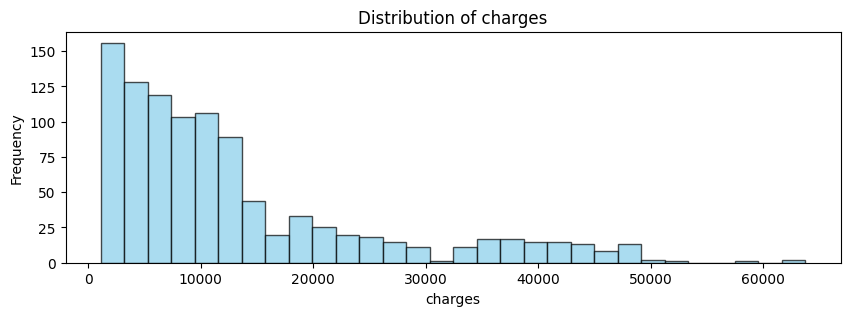

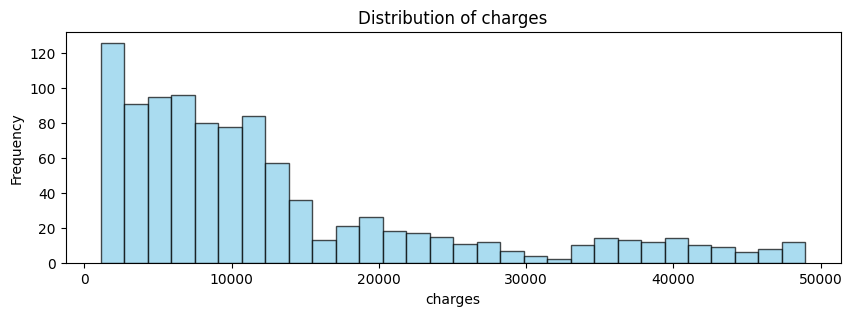

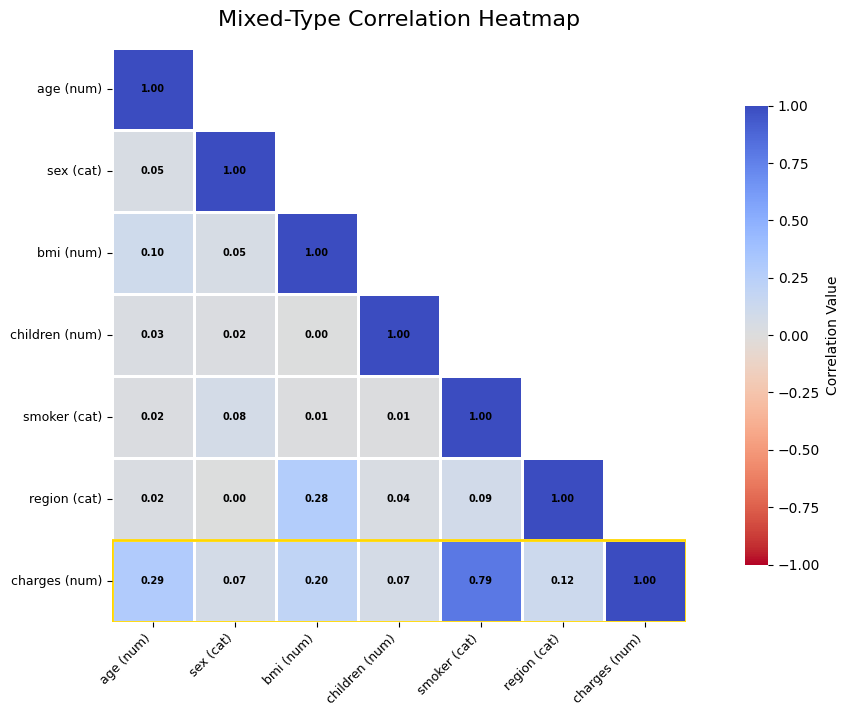

Original Shape: (1003, 7)
Outlier Drop Shape: (997, 7)


In [24]:
hpf.get_target_distribution(train_df, target_var)
hpf.get_target_distribution(hmf.get_outlier_drop(train_df,target_var), target_var)
hpf.mixed_correlation_heatmap(train_df, annot=True, encode=False, target=target_var, figsize=(12,7.1))

print('Original Shape:', train_df.shape)
print('Outlier Drop Shape:', hmf.get_outlier_drop(train_df, target_var).shape)

## Modeling

In [43]:

class AutogluonWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, predictor, feature_names, model_name):
        self.ag_model = predictor
        self.feature_names = feature_names
        self.model_name = model_name

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X, model= self.model_name)

/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:155: FutureWarning: Model's `predict` method contains invalid parameters: {'X'}. Only the following parameter names are allowed: context, model_input, and params. Note that invalid parameters will no longer be permitted in future versions.
  param_names = _check_func_signature(func, "predict")
/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [26]:
# (X,Y) split
x_train = train_df.drop(columns=[target_var])
y_train = train_df[target_var]
x_test = test_df.drop(columns=[target_var])
y_test = test_df[target_var]

# mlflow data format
dataset_train : PandasDataset = mlflow.data.from_pandas(train_df, name = "train")
dataset_test : PandasDataset = mlflow.data.from_pandas(test_df, name = "test")

In [8]:
display(init_values)

from autogluon.tabular import TabularPredictor

if input('Do you want to run Autogluon? (y/n)') == 'y':
    # Autogluon
    predictor = TabularPredictor(problem_type='regression',
                                 label = target_var,
                                 eval_metric = 'rmse',
                                 path = autogluon_path + '/full_predictor'
                                 )
    predictor = predictor.fit(train_data = train_df,
                              presets = preset_mode,
                              holdout_frac = 0.15,
                              time_limit = time_limit,
                              memory_limit = 8)
    print('Autogluon trained')
else:
    print('Autogluon not trained')

{'target_var': 'charges',
 'preset_mode': 'medium_quality',
 'time_limit': 600,
 'outlier_drop': True,
 'autogluon_path': './charges_autogluon/medium_quality'}

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
Memory Avail:       1.35 GB / 8.00 GB (16.9%)
Disk Space Avail:   69.21 GB / 228.27 GB (30.3%)
Presets specified: ['medium_quality']
Enforcing custom memory (soft) limit of 8 GB!
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/Users/delfosg/Documents/aoutgluon-mlflow-integration/charges_autogluon/medium_quality/full_predictor"
Train Data Rows:    1003
Train Data Columns: 6
Label Column:       charges
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    8040.94 MB
	Train Data (Original)  Memory U

Autogluon trained


In [27]:
experiment_path = 'experiements/'
experiment_name = f'{target_var}_{preset_mode}_experiment'
experiment_id = hmf.get_experiment(experiment_name, experiment_path)
mlflow.set_experiment(experiment_name)

The existing experiment charges_medium_quality_experiment has been set up successfully


<Experiment: artifact_location='file:///Users/delfosg/Documents/aoutgluon-mlflow-integration/mlruns/877994864440623537', creation_time=1745811106702, experiment_id='877994864440623537', last_update_time=1745811106702, lifecycle_stage='active', name='charges_medium_quality_experiment', tags={}>

In [ ]:
import time
start_time = time.time() 

#autogluon_loading
full_predictor = TabularPredictor.load(autogluon_path + '/full_predictor')

leaderboar_train = full_predictor.leaderboard(data=train_df, extra_info=True)
leaderboar_test  = full_predictor.leaderboard(data=test_df, extra_info=True)

top_n = 3
for selected_model in leaderboar_train.loc[:top_n, 'model']:
    print(f"Selected Model: {selected_model}")
    
    # create deployment predictor
    deployment_predictor = full_predictor.clone(path = f'{autogluon_path}/deployment_clones/{selected_model}',
                                               return_clone = True,
                                               dirs_exist_ok=True)
    deployment_predictor.set_model_best(model=selected_model,
                                        save_trainer=True)
    deployment_predictor.delete_models(models_to_keep=selected_model,
                                       dry_run=False)
    deployment_predictor.save_space()
    
    model_to_load = AutogluonWrapper(predictor=deployment_predictor,
                                     feature_names=x_test.columns,
                                     model_name = selected_model)
    
    
    
    #  start mlflow run
    with mlflow.start_run(description=f'{selected_model}_{preset_mode}'):
        
        signature = mlflow.models.infer_signature(x_test, y_test)
        
        mlflow.pyfunc.log_model(artifact_path="model",
                                python_model=model_to_load,
                                signature=signature)
        
        # log model type
        spec = model_to_load.ag_model._trainer.load_model(selected_model)
        info = spec.get_info()
        hmf.pop_all_ocurrences(info, 'feature_metadata')
        mlflow.log_param('model_type', info['model_type'])
        # log extra info
        mlflow.log_param('features', info['features'])
        mlflow.log_param('pred_time_test', leaderboar_test.loc[leaderboar_test['model'] == selected_model, 'pred_time_test'].values[0])
        mlflow.log_param('test_size', test_df.shape[0])
        # log hyperparameters
        hyperparameters = info['hyperparameters']
        hyperparameters.update(info['hyperparameters_fit'])
        #log features
        mlflow.log_params({'model_input': info['features']})
        
        # if staker or bagged ensemble
        if info['model_type'] == 'WeightedEnsembleModel':
            #log weights
            mlflow.log_params({'Model_Weights_Ensamble': info['children_info']['S1F1']['model_weights']})
            mlflow.log_params({'Child_Model_Types_Bagging': info['bagged_info']['child_model_type']})
            mlflow.log_params({'Num_Child_Models_Bagging': info['bagged_info']['num_child_models']})
        elif info['model_type'] == 'StackerEnsembleModel':
            #log weights
            mlflow.log_params({'Model_Types_Bagging': info['bagged_info']['child_model_type']})
            mlflow.log_params({'Num_Child_Models_Stacking': info['bagged_info']['num_child_models']})
            # log hyperparameters  of model on top layer
            if info['bagged_info']['num:child_models'] == 1:
                hyperparams_child = info['children_info']['S1F1']['hyperparameters']
                mlflow.log_params({'Hyperparameters_Child_Model': hyperparams_child})
            mlflow.log_params({'Stacker_Info_Models_Beneath' : info['stacker_info']})
        else:
            mlflow.log_params({'Hyperparameters': hyperparameters})
            
    
        #log datasets
        mlflow.log_input(dataset_train, 'Train')
        mlflow.log_input(dataset_test, 'Test')
        
        # metrics (test)
        y_test_pred = model_to_load.predict(x_test)
        result_test, mse, rmse, mae, r2 = hmf.evaluate_model(y_test, y_test_pred)
        mlflow.log_metric('rmse_test', rmse)
        mlflow.log_metric('mse_test', mse)
        mlflow.log_metric('mae_test', mae)
        mlflow.log_metric('r2_test', r2)
        
        # metrics (train)
        y_train_pred = model_to_load.predict(x_train)
        result_train, mse, rmse, mae, r2 = hmf.evaluate_model(y_train, y_train_pred)
        mlflow.log_metric('rmse_train', rmse)
        mlflow.log_metric('mse_train', mse)
        mlflow.log_metric('mae_train', mae)
        mlflow.log_metric('r2_train', r2)
        
        # error plot
        error_plot = hpf.get_error_plot(result_test)
        mlflow.log_figure(figure=error_plot,
                          artifact_file='error_plot_test.png')
        error_plot = hpf.get_error_plot(result_train)
        mlflow.log_figure(figure=error_plot,
                          artifact_file='error_plot_train.png')

/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecu

Selected Model: RandomForestMSE


/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/mlflow/pyfunc/__init__.py:3224: UserWarning: An input example was not provided when logging the model. To ensure

Selected Model: ExtraTreesMSE


/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/mlflow/pyfunc/__init__.py:3224: UserWarning: An input example was not provided when logging the model. To ensure

Selected Model: LightGBMLarge


Deleting model WeightedEnsemble_L2. All files under /Users/delfosg/Documents/aoutgluon-mlflow-integration/charges_autogluon/medium_quality/deployment_clones/LightGBMLarge/models/WeightedEnsemble_L2 will be removed.
/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  

Selected Model: XGBoost


/Users/delfosg/Documents/aoutgluon-mlflow-integration/venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
Deleting model NeuralNetFastAI. All files under /Users/delfosg/Documents/aoutgluon-mlflow-integration/charges_autogluon/medium_quality/deployment_clones/XGBoost/models/NeuralNetFastAI will be removed.
Deleting model NeuralNetTorch. All files under /Users/delfosg/Documents/aoutgluon-mlflow-integration/charges_autogluon/medium_quality/deployment_clones/XGBoost/models/NeuralNetTorch will be removed.